In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from plume_sim import OdorPredictor
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from itertools import groupby
from operator import itemgetter
import multiprocessing as mp

%load_ext autoreload
%autoreload 2

2024-12-19 09:08:58.617188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 09:08:58.628478: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 09:08:58.631864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 09:08:59.282690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dfres = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5') 

In [3]:
index = osc.get_index(dfres.odor,4.5)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

dfres['distance_along_streakline']=dfres.distance_along_streakline*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign



In [4]:
def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,th)
index_nowhiff = get_index_nowhiff(dfres.odor,th)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
wc_wsd_nowhiff(dfres, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dfres,index_nowhiff,fdf_nowhiff)

# fdf.keys()

<!-- #### Likelihood of Estimation of probability - Gaussian Prob + Real world -  -->

Optimal Parameters:
A = 0.015794278293630264
x0 = 0.0
y0 = 0.0
sigma_x = 19.00267515090642
sigma_y = 0.45614510099107247
theta = 3.126665350192221


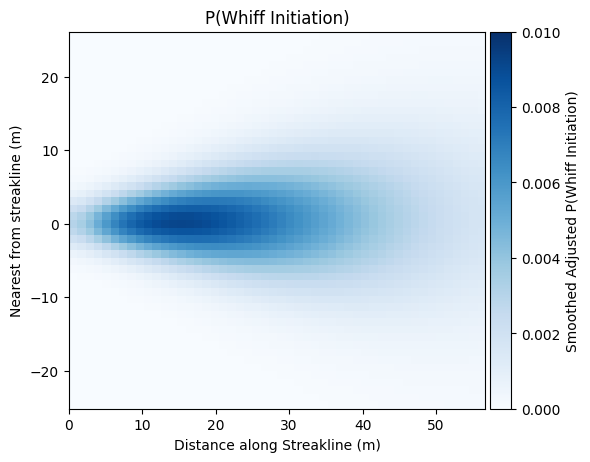

In [970]:
n_bins_x=n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dfres['distance_along_streakline'], 
                                               dfres['nearest_from_streakline'], 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dfres['whiff_flag'])

# Histogram for total data points (irrespective of whiff initiation)
heatmap_total, _, _ = np.histogram2d(dfres['distance_along_streakline'], 
                                     dfres['nearest_from_streakline'], 
                                     bins=[n_bins_x, n_bins_y])

# Calculate the probability as number of whiff initiation points / total number of data points
with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)


def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_x, base_sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y, damping_factor):
    """Calculate a directional Gaussian plume model with dynamic spread."""
    distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    sigma_x = base_sigma_x + distance_scale_factor_x * np.sqrt(distance_from_source)
    sigma_y = base_sigma_y + distance_scale_factor_y * distance_from_source 
    
    xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
    yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)

    p = A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2))) * np.exp(-damping_factor / (distance_from_source + 1))
    return p

x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Flatten arrays
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Exclude bins with zero observations
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor = params
    p = directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)


# initial_params = [1.0, 0.0, 0.0, 50, 5, 0.0, 0.01, 0.1] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y
initial_params = [1.0, 0.0, 0.0, 30, 3, 0.0, 0.6, 0.3, 0.8] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y

# Bounds as discussed
bounds = [
    (0, 1),    # A ≥ 0
    (0, 0), # x0 unbounded
    (0, 0), # y0 unbounded
    (1e-5, None), # sigma_x ≥ 1e-5
    (1e-5, None), # sigma_y ≥ 1e-5
    (0, np.pi),  # theta ∈ [-π, π]
    (0,1),
    (0,1),
    (0.5,2)
]

# Perform the optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_x = {optimal_params[3]}")
print(f"sigma_y = {optimal_params[4]}")
print(f"theta = {optimal_params[5]}")

# Compute fitted probabilities50
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
fitted_p_heatmap_spatial = fitted_p.reshape((len(x_centers), len(y_centers)))

def smooth_heatmap_adjustment(heatmap, region_mask, adjustment_factor, sigma=1.0):
    # Apply the adjustment to the specified region
    adjusted_heatmap = heatmap.copy()
    adjusted_heatmap[region_mask] *= adjustment_factor
    smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
    return smoothed_heatmap

region_mask = (X_centers > 10) & (X_centers < 15)  # Adjust region between 10m and 15m along the streakline
adjustment_factor = 1  # Reduce probability by 20% in this region
sigma_smoothing = 2.0  # Gaussian smoothing standard deviation

# Smoothly adjust the fitted probability heatmap
smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(fitted_p_heatmap_spatial, region_mask, adjustment_factor, sigma=sigma_smoothing)

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.imshow(
    smoothed_fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Smoothed Adjusted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('P(Whiff Initiation)')

f.tight_layout()


In [934]:
fitted_p_heatmap_1=smoothed_fitted_p_heatmap
dfres['spatial_prob'] = 0  # Default to 0 for all rows

for i, row in dfres.iterrows():
    dist_along = row['distance_along_streakline']
    nearest_from = row['nearest_from_streakline']
    
    x_bin = np.digitize([dist_along], xedges)[0] - 1
    y_bin = np.digitize([nearest_from], yedges)[0] - 1

    if (0 <= x_bin < fitted_p_heatmap_1.shape[0] and 0 <= y_bin < fitted_p_heatmap_1.shape[1]):
        spatial_prob = fitted_p_heatmap_1[x_bin, y_bin]
    else:
        spatial_prob = 0  # Default to 0 if outside bounds

    # Assign the spatial probability to the new column
    dfres.at[i, 'spatial_prob'] = spatial_prob

In [8]:
# from scipy.stats import gaussian_kde

# # Assuming fdf is the DataFrame with relevant columns: 'avg_distance_along_streakline', 'avg_nearest_from_streakline', 'odor_intermittency'

# # Updated bin definitions with merged bins
# distance_bins = np.arange(0, 60, 10)  # 0 to 60 meters, 10-meter intervals
# nearest_bins = [-10, -5, 0, 5, 15]   # Merged bins: [-10--5m], [-5-0m], [0-5m], [5-15m]
#   # Merged bins: [-10--5m], [-5-0m], [0-5m], [5-15m]

# # Create a 2D dictionary to store KDE functions for each bin
# kde_dict_2d = {}

# # Fit KDE for each 2D bin
# for i in range(len(distance_bins) - 1):
#     for j in range(len(nearest_bins) - 1):
#         start_dist, end_dist = distance_bins[i], distance_bins[i + 1]
#         start_nearest, end_nearest = nearest_bins[j], nearest_bins[j + 1]
        
#         # Filter data within the current 2D bin
#         bin_data = fdf[
#             (fdf['avg_distance_along_streakline'] >= start_dist) &
#             (fdf['avg_distance_along_streakline'] < end_dist) &
#             (fdf['avg_nearest_from_streakline'] >= start_nearest) &
#             (fdf['avg_nearest_from_streakline'] < end_nearest)
#         ]
        
#         intermittency_values = bin_data['odor_intermittency'].dropna().values
        
#         # Fit KDE if there are enough data points
#         if len(intermittency_values) > 3:
#             kde = gaussian_kde(intermittency_values, bw_method='scott')
#             kde_dict_2d[(start_dist, end_dist, start_nearest, end_nearest)] = kde
#         else:
#             kde_dict_2d[(start_dist, end_dist, start_nearest, end_nearest)] = None

# # Plot the KDE distributions for each bin
# fig, axes = plt.subplots(len(distance_bins) - 1, len(nearest_bins) - 1, figsize=(15, 10), sharex=True, sharey=True)
# fig.suptitle('KDE of Intermittency Values for Each 2D Bin', fontsize=16)

# for i, (start_dist, end_dist) in enumerate(zip(distance_bins[:-1], distance_bins[1:])):
#     for j, (start_nearest, end_nearest) in enumerate(zip(nearest_bins[:-1], nearest_bins[1:])):
#         ax = axes[i, j]
        
#         # Get KDE and data points for the current bin
#         kde = kde_dict_2d.get((start_dist, end_dist, start_nearest, end_nearest))
#         bin_data = fdf[
#             (fdf['avg_distance_along_streakline'] >= start_dist) &
#             (fdf['avg_distance_along_streakline'] < end_dist) &
#             (fdf['avg_nearest_from_streakline'] >= start_nearest) &
#             (fdf['avg_nearest_from_streakline'] < end_nearest)
#         ]
#         intermittency_values = bin_data['odor_intermittency'].dropna().values

#         # Plot the data points for the bin
#         ax.scatter(intermittency_values, np.zeros_like(intermittency_values), alpha=0.5, color='blue', label='Data Points')

#         # Plot the KDE curve if available
#         if kde is not None:
#             x_vals = np.linspace(min(intermittency_values), max(intermittency_values), 1000)
#             y_vals = kde(x_vals)
#             ax.plot(x_vals, y_vals, color='red', lw=2, label='KDE Curve')

#         # Titles and labels
#         ax.set_title(f'D: {start_dist}-{end_dist}m, N: {start_nearest}-{end_nearest}m')
#         ax.set_xlabel('Intermittency (s)')
#         ax.set_ylabel('Density')
#         ax.legend()

# plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.show()


In [9]:
# distance_bins = np.arange(0, 60, 5)  # 0 to 60 meters, 5-meter intervals

# # Create a dictionary to store KDE functions for each distance bin
# kde_dict_1d = {}

# # Fit KDE for each distance bin
# for i in range(len(distance_bins) - 1):
#     start_dist, end_dist = distance_bins[i], distance_bins[i + 1]
    
#     # Filter data within the current distance bin
#     bin_data = fdf[
#         (fdf['avg_distance_along_streakline'] >= start_dist) &
#         (fdf['avg_distance_along_streakline'] < end_dist)
#     ]
    
#     intermittency_values = bin_data['odor_intermittency'].dropna().values
    
#     # Fit KDE if there are enough data points
#     if len(intermittency_values) > 5:
#         kde = gaussian_kde(intermittency_values, bw_method='scott')
#         kde_dict_1d[(start_dist, end_dist)] = kde
#     else:
#         kde_dict_1d[(start_dist, end_dist)] = None

# # Function to generate a random intermittency based on distance using KDE
# def generate_intermittency_1d(distance):
#     for (start_dist, end_dist), kde in kde_dict_1d.items():
#         if start_dist <= distance < end_dist:
#             if kde is not None:
#                 return np.abs(kde.resample(1)[0][0])
#             else:
#                 # Return the median intermittency value for the bin if no KDE is available
#                 bin_data = fdf[
#                     (fdf['avg_distance_along_streakline'] >= start_dist) &
#                     (fdf['avg_distance_along_streakline'] < end_dist)
#                 ]
#                 median_intermittency = bin_data['odor_intermittency'].median()
#                 return median_intermittency if pd.notnull(median_intermittency) else 0.03
#     # Default value if location is out of range
#     return 0.03




In [10]:
# kde_dict_1d = {}
# distance_bins = np.arange(0, 60, 5) 
# # Fit KDE for each distance bin
# for i in range(len(distance_bins) - 1):
#     start_dist, end_dist = distance_bins[i], distance_bins[i + 1]
    
#     # Filter data within the current distance bin
#     bin_data = fdf[
#         (fdf['avg_distance_along_streakline'] >= start_dist) &
#         (fdf['avg_distance_along_streakline'] < end_dist)
#     ]
    
#     intermittency_values = bin_data['odor_intermittency'].dropna().values
    
#     # Fit KDE if there are enough data points
#     if len(intermittency_values) > 5:
#         kde = gaussian_kde(intermittency_values, bw_method='scott')
#         kde_dict_1d[(start_dist, end_dist)] = kde
#     else:
#         kde_dict_1d[(start_dist, end_dist)] = None

# def generate_intermittency_1d_(distance, max_distance=50, min_scale=0.5, max_scale=2):
#     """Generate intermittency based on KDE sampling and scale it inversely with distance."""
#     for (start_dist, end_dist), kde in kde_dict_1d.items():
#         if start_dist <= distance < end_dist:
#             if kde is not None:
#                 # Sample intermittency from KDE
#                 sampled_intermittency = np.abs(kde.resample(1)[0][0])
#             else:
#                 # Default to median if no KDE is available
#                 bin_data = fdf[
#                     (fdf['avg_distance_along_streakline'] >= start_dist) &
#                     (fdf['avg_distance_along_streakline'] < end_dist)
#                 ]
#                 sampled_intermittency = bin_data['odor_intermittency'].median() or 0.05
            
#             # Scale the sampled intermittency inversely with distance
#             normalized_distance = np.clip(distance / max_distance, 0, 1)
#             scale_factor = max_scale - (max_scale - min_scale) * (1 - normalized_distance)
#             scaled_intermittency = sampled_intermittency * scale_factor

#             return max(scaled_intermittency, 0.05)  
#     return 0.05


In [12]:
# from scipy.stats import gaussian_kde

# # Updated bin definitions with merged bins
# distance_bins = np.arange(0, 60, 15)  # 0 to 60 meters, 10-meter intervals
# nearest_bins = [-10, -5, 0, 5, 15]   # Merged bins: [-10--5m], [-5-0m], [0-5m], [5-15m]

# # Create a 2D dictionary to store KDE functions for each bin
# # kde_dict_2d = {}
# # Function to generate a random intermittency based on 2D distance using KDE
# # def generate_intermittency_2d(distance, nearest):
# #     for (start_dist, end_dist, start_nearest, end_nearest), kde in kde_dict_2d.items():
# #         if start_dist <= distance < end_dist and start_nearest <= nearest < end_nearest:
# #             if kde is not None:
# #                 return np.abs(kde.resample(1)[0][0])
# #             else:
# #                                 # Return the median intermittency value for the bin if no KDE is available
# #                 bin_data = fdf[
# #                     (fdf['avg_distance_along_streakline'] >= start_dist) &
# #                     (fdf['avg_distance_along_streakline'] < end_dist) &
# #                     (fdf['avg_nearest_from_streakline'] >= start_nearest) &
# #                     (fdf['avg_nearest_from_streakline'] < end_nearest)
# #                 ]
# #                 median_intermittency = bin_data['odor_intermittency'].median()
# #                 return median_intermittency if pd.notnull(median_intermittency) else 0.03
# #   # Default value if no KDE available
# #     return 0.03  # Default value if location is out of range



# # Function to merge bins
# def merge_sparse_bins(fdf, distance_bins, nearest_bins, min_points=5):
#     kde_dict_2d = {}
#     merged_bins = []
    
#     # First identify all sparse bins
#     sparse_bins = set()  # Using set for more efficient lookups
#     bin_data_counts = {}  # Store data counts for each bin
    
#     # First pass: identify sparse bins and store data counts
#     for i in range(len(distance_bins) - 1):
#         for j in range(len(nearest_bins) - 1):
#             start_dist, end_dist = distance_bins[i], distance_bins[i + 1]
#             start_nearest, end_nearest = nearest_bins[j], nearest_bins[j + 1]
            
#             bin_data = fdf[
#                 (fdf['avg_distance_along_streakline'] >= start_dist) &
#                 (fdf['avg_distance_along_streakline'] < end_dist) &
#                 (fdf['avg_nearest_from_streakline'] >= start_nearest) &
#                 (fdf['avg_nearest_from_streakline'] < end_nearest)
#             ]
#             n_points = len(bin_data)
#             bin_data_counts[(i, j)] = n_points
            
#             if n_points <= min_points:
#                 sparse_bins.add((i, j))
    
#     # Second pass: create KDEs with smart merging
#     for i in range(len(distance_bins) - 1):
#         for j in range(len(nearest_bins) - 1):
#             if (i, j) in sparse_bins:
#                 # Find best neighboring bin to merge with
#                 neighbors = []
#                 for di in [-1, 0, 1]:
#                     for dj in [-1, 0, 1]:
#                         ni, nj = i + di, j + dj
#                         if (0 <= ni < len(distance_bins)-1 and 
#                             0 <= nj < len(nearest_bins)-1 and 
#                             (ni, nj) not in sparse_bins):
#                             neighbors.append((ni, nj, bin_data_counts.get((ni, nj), 0)))
                
#                 if neighbors:
#                     # Sort by data count and pick the richest neighbor
#                     best_neighbor = max(neighbors, key=lambda x: x[2])
#                     ni, nj = best_neighbor[0], best_neighbor[1]
                    
#                     # Define merged bin boundaries
#                     start_dist = min(distance_bins[i], distance_bins[ni])
#                     end_dist = max(distance_bins[i+1], distance_bins[ni+1])
#                     start_nearest = min(nearest_bins[j], nearest_bins[nj])
#                     end_nearest = max(nearest_bins[j+1], nearest_bins[nj+1])
#                 else:
#                     # If no good neighbors, use original boundaries
#                     start_dist, end_dist = distance_bins[i], distance_bins[i + 1]
#                     start_nearest, end_nearest = nearest_bins[j], nearest_bins[j + 1]
#             else:
#                 start_dist, end_dist = distance_bins[i], distance_bins[i + 1]
#                 start_nearest, end_nearest = nearest_bins[j], nearest_bins[j + 1]
            
#             bin_data = fdf[
#                 (fdf['avg_distance_along_streakline'] >= start_dist) &
#                 (fdf['avg_distance_along_streakline'] < end_dist) &
#                 (fdf['avg_nearest_from_streakline'] >= start_nearest) &
#                 (fdf['avg_nearest_from_streakline'] < end_nearest)
#             ]
            
#             intermittency_values = bin_data['odor_intermittency'].dropna().values
            
#             if len(intermittency_values) > min_points:
#                 kde = gaussian_kde(intermittency_values, bw_method='scott')
#                 kde_dict_2d[(start_dist, end_dist, start_nearest, end_nearest)] = kde
#                 merged_bins.append((start_dist, end_dist, start_nearest, end_nearest))
    
#     return kde_dict_2d, merged_bins

# # Create merged KDE dictionary
# kde_dict_2d, merged_bins = merge_sparse_bins(fdf, distance_bins, nearest_bins)



# def generate_intermittency_2d(distance_along, distance_from):
#     """
#     Generate intermittency using 2D KDE with proper error handling
#     """
#     try:
#         for (start_dist, end_dist, start_nearest, end_nearest), kde in kde_dict_2d.items():
#             if (start_dist <= distance_along < end_dist and 
#                 start_nearest <= distance_from < end_nearest):
                
#                 if kde is not None:
#                     # Sample from KDE
#                     intermittency = np.abs(kde.resample(1)[0][0])
#                 else:
#                     # Get median from bin data
#                     bin_data = fdf[
#                         (fdf['avg_distance_along_streakline'] >= start_dist) &
#                         (fdf['avg_distance_along_streakline'] < end_dist) &
#                         (fdf['avg_nearest_from_streakline'] >= start_nearest) &
#                         (fdf['avg_nearest_from_streakline'] < end_nearest)
#                     ]
#                     median = bin_data['odor_intermittency'].median()
                    
#                     # If median is NaN, use nearest non-empty bin or default value
#                     if pd.isna(median):
#                         # Find nearest non-empty bin
#                         nearest_bin_data = fdf[
#                             (fdf['avg_distance_along_streakline'].between(start_dist-5, end_dist+5)) &
#                             (fdf['avg_nearest_from_streakline'].between(start_nearest-5, end_nearest+5))
#                         ]
#                         intermittency = nearest_bin_data['odor_intermittency'].median()
#                         if pd.isna(intermittency):
#                             intermittency = 0.05  # Default value if no nearby data
#                     else:
#                         intermittency = median
                
#                 # Ensure we return a valid number
#                 if pd.isna(intermittency):
#                     return 0.05
                    
#                 return np.clip(intermittency, 0.03, 4.0)
                
#         # If we didn't find a matching bin
#         return 0.05
        
#     except Exception as e:
#         print(f"Error in generate_intermittency_2d: {e}")
#         return 0.05  # Return default value on error



In [329]:
# import matplotlib.patches as patches
# from scipy.stats import gaussian_kde
# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize

# def plot_kde_availability_2d(kde_dict_2d, distance_bins, nearest_bins):
#     """Plot KDE availability for each 2D bin."""
#     fig, ax = plt.subplots(figsize=(10, 6))

#     for (start_dist, end_dist, start_nearest, end_nearest), kde in kde_dict_2d.items():
#         # Color bins with KDE in darkblue, without KDE in white
#         color = 'darkblue' if kde is not None else 'white'
        
#         # Create a rectangle for each bin
#         rect = patches.Rectangle(
#             (start_dist, start_nearest),
#             end_dist - start_dist,
#             end_nearest - start_nearest,
#             linewidth=1,
#             edgecolor='black',
#             facecolor=color
#         )
#         ax.add_patch(rect)

#     # Add bin centers as red dots
#     distance_centers = (distance_bins[:-1] + distance_bins[1:]) / 2
#     nearest_centers = (np.array(nearest_bins[:-1]) + np.array(nearest_bins[1:])) / 2
#     X, Y = np.meshgrid(distance_centers, nearest_centers)
#     ax.scatter(X.flatten(), Y.flatten(), color='red', label='Bin Centers')

#     # Axis labels and title
#     ax.set_xlabel('Distance Along Streakline (m)')
#     ax.set_ylabel('Nearest From Streakline (m)')
#     ax.set_title('KDE Availability for Each 2D Bin')

#     # Create a ScalarMappable and add a colorbar (this is just a static colorbar for the example)
#     plt.colorbar(ScalarMappable(norm=Normalize(vmin=0, vmax=1), cmap='Blues'), label='KDE Availability')
#     ax.legend()
#     plt.grid(True)
#     plt.show()


# def plot_kde_distributions_2d(kde_dict_2d, fdf, distance_bins, nearest_bins, n_bins=20):
#     """
#     Plot both KDE curves and histograms (raw counts and PMF) for intermittency values in each 2D bin.
#     We create a grid of subplots, one for each 2D bin, showing:
#       - Data points (as a rug plot on the x-axis)
#       - A histogram of raw counts and the corresponding PMF
#       - The KDE curve if available
#     """
#     fig, axes = plt.subplots(len(nearest_bins) - 1, len(distance_bins) - 1, figsize=(15, 10), sharex=True, sharey=False)
#     fig.suptitle('Intermittency Distributions (Raw Counts, PMF, and KDE) for Each 2D Bin', fontsize=16)

#     # Predefine a range of intermittency values if you want a consistent scale
#     # Otherwise, each subplot uses the local min/max
#     # global_min = fdf['odor_intermittency'].min()
#     # global_max = fdf['odor_intermittency'].max()

#     for i, (start_dist, end_dist) in enumerate(zip(distance_bins[:-1], distance_bins[1:])):
#         for j, (start_nearest, end_nearest) in enumerate(zip(nearest_bins[:-1], nearest_bins[1:])):
#             ax = axes[j, i]

#             # Extract data for this bin
#             bin_data = fdf[
#                 (fdf['avg_distance_along_streakline'] >= start_dist) &
#                 (fdf['avg_distance_along_streakline'] < end_dist) &
#                 (fdf['avg_nearest_from_streakline'] >= start_nearest) &
#                 (fdf['avg_nearest_from_streakline'] < end_nearest)
#             ]
#             intermittency_values = bin_data['odor_intermittency'].dropna().values
#             kde = kde_dict_2d.get((start_dist, end_dist, start_nearest, end_nearest))

#             if len(intermittency_values) > 0:
#                 # Determine histogram range from the data in this bin
#                 data_min, data_max = intermittency_values.min(), intermittency_values.max()
#                 x_vals = np.linspace(data_min, data_max, 1000)

#                 # Plot raw counts histogram
#                 counts, hist_edges = np.histogram(intermittency_values, bins=n_bins, range=(data_min, data_max))
#                 bin_centers = (hist_edges[:-1] + hist_edges[1:]) / 2
#                 ax.bar(bin_centers, counts, width=(hist_edges[1] - hist_edges[0]) * 0.8, alpha=0.5, color='gray', label='Raw Counts')

#                 # Plot PMF (counts normalized by total count in this bin)
#                 total_count = len(intermittency_values)
#                 if total_count > 0:
#                     pmf = counts / total_count
#                     ax.plot(bin_centers, pmf * max(counts), color='green', marker='o', label='PMF (scaled)')

#                 # Rug plot (data points) at the bottom
#                 ax.plot(intermittency_values, np.zeros_like(intermittency_values), '|', color='blue', markersize=10, alpha=0.7, label='Data Points')

#                 # Plot KDE if available
#                 if kde is not None:
#                     y_vals = kde(x_vals)
#                     # Scale KDE to a comparable height. For example:
#                     # Scale KDE to max(counts) to visually compare shape
#                     scaled_y_vals = (y_vals / y_vals.max()) * max(counts) if y_vals.max() > 0 else y_vals
#                     ax.plot(x_vals, scaled_y_vals, color='red', lw=2, label='KDE Curve (scaled)')

#             # Titles and labels
#             ax.set_title(f'D: {start_dist}-{end_dist}m, N: {start_nearest}-{end_nearest}m', fontsize=10)
#             ax.set_xlabel('Intermittency')
#             ax.set_ylabel('Counts / Density')
#             ax.legend(fontsize=8)

#     plt.tight_layout(rect=[0, 0, 1, 0.97])
#     plt.show()

# distance_bins = np.arange(0, 60, 10)
# nearest_bins = [-10, -5, 0, 5, 15]

# # plot_kde_availability_2d(kde_dict_2d, distance_bins, nearest_bins)
# plot_kde_distributions_2d(kde_dict_2d, fdf, distance_bins, nearest_bins)

In [1438]:
df_test=dfres[10000:]

# Or in one line:
# df_test = dfres[(dfres['time'] >= 2000) & (dfres['time'] <= 2400)]
df_test.reset_index(inplace=True, drop=True)
dt=df_test.master_time[1]-df_test.master_time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time

rows_per_second = 200
base_odor_level = 0.58 


test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
whiff_intermittency=fdf.odor_intermittency.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )

/tmp/ipykernel_529617/4214983674.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time'] = time


In [1439]:
def predict_whiff_from_probability(x, y, hmap, xedges, yedges):
    x_bin = np.digitize(x, xedges) - 1  # -1 because digitize returns 1-based index
    y_bin = np.digitize(y, yedges) - 1

    if x_bin < 0 or x_bin >= hmap.shape[0] or y_bin < 0 or y_bin >= hmap.shape[1]:
        return False, 0  # No valid bin, so no whiff predicted, probability is 0
    whiff_prob = hmap[x_bin, y_bin]
    whiff_predicted = np.random.rand() < whiff_prob  # True if random number is less than the probability

    return whiff_predicted, whiff_prob

In [973]:
# ## Intermittency
# ## 2D

# distance_bins = np.arange(0, 60, 15)
# nearest_bins = [-10, -5, 0, 5, 15]

# # Create a dictionary mapping from bin boundaries to observed values
# bin_data_dict = {}
# for i in range(len(distance_bins)-1):
#     for j in range(len(nearest_bins)-1):
#         start_dist, end_dist = distance_bins[i], distance_bins[i+1]
#         start_nearest, end_nearest = nearest_bins[j], nearest_bins[j+1]
        
#         bin_data = fdf[
#             (fdf['avg_distance_along_streakline'] >= start_dist) &
#             (fdf['avg_distance_along_streakline'] < end_dist) &
#             (fdf['avg_nearest_from_streakline'] >= start_nearest) &
#             (fdf['avg_nearest_from_streakline'] < end_nearest)
#         ]['odor_intermittency'].dropna().values
        
#         bin_data_dict[(start_dist, end_dist, start_nearest, end_nearest)] = bin_data

# def generate_intermittency_2d_bootstrap(distance_along, distance_from, default=0.05):
#     # Find which bin this point belongs to
#     for (sd, ed, sn, en), values in bin_data_dict.items():
#         if sd <= distance_along < ed and sn <= distance_from < en:
#             if len(values) > 0:
#                 # Bootstrap sample: pick a random observed value
#                 intermittency = np.random.choice(values)
#                 # Clip to a reasonable range if desired
#                 return np.clip(intermittency, 0.03, 4.0)
#     return default  # If no bin match or empty bin, return a default



# n_hist_bins = 30  # Number of bins to discretize intermittency values

# bin_pmf_dict = {}
# for (sd, ed, sn, en), values in bin_data_dict.items():
#     if len(values) > 0:
#         # Compute histogram of intermittency values
#         hist_counts, hist_edges = np.histogram(values, bins=n_hist_bins, density=False)
#         total = np.sum(hist_counts)
#         if total > 0:
#             pmf = hist_counts / total
#         else:
#             pmf = np.zeros_like(hist_counts)

#         bin_pmf_dict[(sd, ed, sn, en)] = (pmf, hist_edges)

# def generate_intermittency_2d_pmf(distance_along, distance_from, default=0.05):
#     for (sd, ed, sn, en), (pmf, hist_edges) in bin_pmf_dict.items():
#         if sd <= distance_along < ed and sn <= distance_from < en:
#             if np.sum(pmf) > 0:
#                 # Sample a bin index according to pmf
#                 bin_index = np.random.choice(len(pmf), p=pmf)
#                 # Randomly pick a value within that bin range for continuity
#                 bin_start = hist_edges[bin_index]
#                 bin_end = hist_edges[bin_index+1]
#                 intermittency = np.random.uniform(bin_start, bin_end)
#                 return np.clip(intermittency, 0.03, 4.0)
#     return default

# # Suppose we define thresholds and modify the sampling procedure based on recent history
# low_threshold = 0.005
# history_length = 10
# recent_intermittencies = [0.03, 0.5, 0.009]  # Example recent history

# def generate_intermittency_2d_temporal(distance_along, distance_from, default=0.05):
#     # Check recent history
#     last_values = np.array(recent_intermittencies[-history_length:])
#     low_frequency = np.mean(last_values < low_threshold)
    
#     # The higher low_frequency is, the more we bias towards lower intermittency
#     for (sd, ed, sn, en), values in bin_data_dict.items():
#         if sd <= distance_along < ed and sn <= distance_from < en:
#             if len(values) > 0:
#                 # If recent were mostly low, weight selection towards lower half of distribution
#                 if low_frequency > 0.5:
#                     # Focus on lower intermittency values
#                     subset = values[values < np.median(values)]
#                     if len(subset) > 0:
#                         intermittency = np.random.choice(subset)
#                         return np.clip(intermittency, 0.03, 4.0)
#                     else:
#                         # fallback to full distribution if subset empty
#                         intermittency = np.random.choice(values)
#                         return np.clip(intermittency, 0.03, 4.0)
#                 else:
#                     # Normal sampling
#                     intermittency = np.random.choice(values)
#                     return np.clip(intermittency, 0.03, 4.0)
#     return default




In [1465]:
## 1D
distance_bins_intermittency_1d = np.arange(0, 60, 15)  # For example, 0 to 60 in steps of 5

bin_data_dict_1d = {}

for i in range(len(distance_bins_intermittency_1d)-1):
    start_dist, end_dist = distance_bins_intermittency_1d[i], distance_bins_intermittency_1d[i+1]

    bin_data = fdf[
        (fdf['avg_distance_along_streakline'] >= start_dist) &
        (fdf['avg_distance_along_streakline'] < end_dist)
    ]['odor_intermittency'].dropna().values

    bin_data_dict_1d[(start_dist, end_dist)] = bin_data


def generate_intermittency_1d_bootstrap(distance, default=0.05):
    # Find which bin this distance falls into
    for (sd, ed), values in bin_data_dict_1d.items():
        if sd <= distance < ed:
            if len(values) > 0:
                # Just pick a random observed value from that bin
                intermittency = np.random.choice(values)
                return np.clip(intermittency, np.min(intermittency), np.max(intermittency))
    return default


n_hist_bins = 30
bin_pmf_dict_1d = {}

for (sd, ed), values in bin_data_dict_1d.items():
    if len(values) > 0:
        hist_counts, hist_edges = np.histogram(values, bins=n_hist_bins, density=False)
        total = np.sum(hist_counts)
        if total > 0:
            pmf = hist_counts / total
        else:
            pmf = np.zeros_like(hist_counts)

        bin_pmf_dict_1d[(sd, ed)] = (pmf, hist_edges)
    else:
        bin_pmf_dict_1d[(sd, ed)] = (None, None)


def generate_intermittency_1d_pmf(distance, default=0.05):
    for (sd, ed), (pmf, hist_edges) in bin_pmf_dict_1d.items():
        if sd <= distance < ed:
            if pmf is not None and np.sum(pmf) > 0:
                bin_index = np.random.choice(len(pmf), p=pmf)
                bin_start = hist_edges[bin_index]
                bin_end = hist_edges[bin_index + 1]
                intermittency = np.random.uniform(bin_start, bin_end)
                return np.clip(intermittency, 0.03, 4.0)
    return default


low_threshold = 0.05
history_length = 7
recent_intermittencies = np.random.choice(whiff_intermittency,5)  # Example recent history

def generate_intermittency_1d_temporal(distance, default=0.05):
    # Compute low frequency from recent history
    last_values = np.array(recent_intermittencies[-history_length:])
    low_frequency = np.mean(last_values < low_threshold)
    
    for (sd, ed), values in bin_data_dict_1d.items():
        if sd <= distance < ed:
            if len(values) > 0:
                if low_frequency > 0.5:
                    # If recently low, bias towards lower half
                    median_val = np.median(values)
                    subset = values[values < median_val]
                    if len(subset) > 0:
                        intermittency = np.random.choice(subset)
                    else:
                        intermittency = np.random.choice(values)
                else:
                    # Normal sampling
                    intermittency = np.random.choice(values)
                return np.clip(intermittency,  np.min(intermittency), np.max(intermittency))
    return default


In [1466]:
# import math
# bins_keys = list(bin_data_dict.keys())
# bins_keys.sort(key=lambda x: (x[0], x[2]))  # Sort bins by distance and then nearest

# # Decide how many bins to show
# n_plots = len(bins_keys)
# cols = 5
# rows = math.ceil(n_plots / cols)

# fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharey=False)
# axes = axes.flatten()

# n_hist_bins = 30  # number of bins for histogram

# for idx, (bin_key, values) in enumerate(bin_data_dict.items()):
#     ax = axes[idx]
#     sd, ed, sn, en = bin_key
#     original_values = values

#     if len(original_values) > 0:
#         # Compute the histogram
#         hist_counts, hist_edges = np.histogram(original_values, bins=n_hist_bins, density=False)
#         bin_centers = (hist_edges[:-1] + hist_edges[1:]) / 2
#         total = np.sum(hist_counts)
#         pmf = hist_counts / total if total > 0 else np.zeros_like(hist_counts)

#         # Plot histogram as bars
#         # Here we plot probability as bar height (PMF)
#         # If you prefer raw counts, just use hist_counts instead of pmf.
#         ax.bar(bin_centers, pmf, width=(hist_edges[1] - hist_edges[0]), 
#                alpha=0.7, color='blue', edgecolor='black', label='PMF')

#         # Plot the raw data points
#         # Add a small vertical jitter to separate overlapping points
#         y_jitter = np.random.uniform(0, pmf.max()*0.05, size=len(original_values))
#         # The points are plotted at their intermittency value (x) and a small random height (y_jitter)
#         ax.scatter(original_values, y_jitter, alpha=0.7, color='red', edgecolors='black', s=20, label='Raw Data')

#         # Set axis limits to show bars and points clearly
#         ax.set_xlim(hist_edges[0], hist_edges[-1])
#         # Add a bit of headroom above the max pmf
#         ax.set_ylim(0, pmf.max()*1.1 + pmf.max()*0.05)

#     else:
#         # If no data in this bin, just show an empty plot
#         ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

#     ax.set_title(f'D: {sd}-{ed}m, N: {sn}-{en}m', fontsize=10)
#     ax.set_xlabel('Intermittency')
#     ax.set_ylabel('Probability')
#     ax.legend(fontsize=8)

# # Hide extra axes if any
# for extra_idx in range(n_plots, len(axes)):
#     axes[extra_idx].axis('off')

# plt.tight_layout()

In [1467]:
# distance_bins_2d_duration = np.arange(0, 60, 15)  # example
# nearest_bins = [-10, -5, 0, 5, 15]    # example

# # Dictionary for whiff durations per bin
# bin_whiff_duration_dict = {}
# for i in range(len(distance_bins_2d_duration)-1):
#     for j in range(len(nearest_bins)-1):
#         start_dist, end_dist = distance_bins_2d_duration[i], distance_bins_2d_duration[i+1]
#         start_nearest, end_nearest = nearest_bins[j], nearest_bins[j+1]
        
#         bin_data = fdf[
#             (fdf['avg_distance_along_streakline'] >= start_dist) &
#             (fdf['avg_distance_along_streakline'] < end_dist) &
#             (fdf['avg_nearest_from_streakline'] >= start_nearest) &
#             (fdf['avg_nearest_from_streakline'] < end_nearest)
#         ]['length_of_encounter'].dropna().values
        
#         bin_whiff_duration_dict[(start_dist, end_dist, start_nearest, end_nearest)] = bin_data


# def generate_whiff_duration_2d_bootstrap(distance_along, distance_from, default=1.0):
#     for (sd, ed, sn, en), values in bin_whiff_duration_dict.items():
#         if sd <= distance_along < ed and sn <= distance_from < en:
#             if len(values) > 0:
#                 duration = np.random.choice(values)
#                 # Ensure a minimum and maximum reasonable duration if needed
#                 return np.clip(duration, 0.05, 10.0)  
#     return default


# n_hist_bins = 30
# bin_duration_pmf_dict = {}
# for (sd, ed, sn, en), values in bin_whiff_duration_dict.items():
#     if len(values) > 0:
#         hist_counts, hist_edges = np.histogram(values, bins=n_hist_bins, density=False)
#         total = np.sum(hist_counts)
#         if total > 0:
#             pmf = hist_counts / total
#         else:
#             pmf = np.zeros_like(hist_counts)
#         bin_duration_pmf_dict[(sd, ed, sn, en)] = (pmf, hist_edges)
#     else:
#         bin_duration_pmf_dict[(sd, ed, sn, en)] = (None, None)


# def generate_whiff_duration_2d_pmf(distance_along, distance_from, default=1.0):
#     for (sd, ed, sn, en), (pmf, hist_edges) in bin_duration_pmf_dict.items():
#         if sd <= distance_along < ed and sn <= distance_from < en:
#             if pmf is not None and np.sum(pmf) > 0:
#                 bin_index = np.random.choice(len(pmf), p=pmf)
#                 bin_start = hist_edges[bin_index]
#                 bin_end = hist_edges[bin_index + 1]
#                 duration = np.random.uniform(bin_start, bin_end)
#                 return np.clip(duration, 0.05, 10.0)
#     return default


# low_threshold = 1.0  # Example threshold for what counts as a "low" duration
# history_length = 5
# recent_durations = [0.5, 0.8, 1.2]  # Example recent history

# def generate_whiff_duration_2d_temporal(distance_along, distance_from, default=1.0):
#     last_values = np.array(recent_durations[-history_length:])
#     low_frequency = np.mean(last_values < low_threshold)
    
#     for (sd, ed, sn, en), values in bin_whiff_duration_dict.items():
#         if sd <= distance_along < ed and sn <= distance_from < en:
#             if len(values) > 0:
#                 # If recently low durations are frequent, bias towards lower half
#                 if low_frequency > 0.5:
#                     median_val = np.median(values)
#                     subset = values[values < median_val]
#                     if len(subset) > 0:
#                         duration = np.random.choice(subset)
#                     else:
#                         duration = np.random.choice(values)
#                 else:
#                     # Normal sampling
#                     duration = np.random.choice(values)
#                 return np.clip(duration, 0.05, 10.0)
#     return default

# low_threshold = 0.5  # adjust as needed
# history_length = 5
# recent_durations =  np.random.choice(whiff_duration,5)   # example recent history

# def generate_whiff_duration_2d_temporal_new(distance_along, distance_from, default=0.5):
#     # Compute how many recent durations were low
#     last_values = np.array(recent_durations[-history_length:])
#     low_frequency = np.mean(last_values < low_threshold)

#     # Iterate through the 2D bins
#     for (sd, ed, sn, en), values in bin_whiff_duration_dict.items():
#         if sd <= distance_along < ed and sn <= distance_from < en:
#             if len(values) > 0:
#                 # If we have a high proportion of short whiffs recently,
#                 # bias toward the upper half of durations:
#                 if low_frequency > 0.5:
#                     median_val = np.median(values)
#                     # Select only those durations >= median_val (longer half)
#                     subset = values[values >= median_val]
#                     if len(subset) > 0:
#                         duration = np.random.choice(subset)
#                     else:
#                         # Fallback: if no suitable subset, choose from entire distribution
#                         duration = np.random.choice(values)
#                 else:
#                     # Normal sampling if not dominated by recent short durations
#                     duration = np.random.choice(values)
                
#                 # Clip the duration within a defined range if needed
#                 return np.clip(duration, np.min(whiff_duration), np.max(whiff_duration))
#     return default



In [1468]:
# distance_bins = np.arange(0, 60, 15)  # for example, you can adjust as needed

# bin_whiff_duration_dict_1d = {}
# for i in range(len(distance_bins)-1):
#     start_dist, end_dist = distance_bins[i], distance_bins[i+1]

#     # Filter the data for this distance bin
#     bin_data = fdf[
#         (fdf['avg_distance_along_streakline'] >= start_dist) &
#         (fdf['avg_distance_along_streakline'] < end_dist)
#     ]['length_of_encounter'].dropna().values

#     bin_whiff_duration_dict_1d[(start_dist, end_dist)] = bin_data

# def generate_whiff_duration_1d_bootstrap(distance, default=1.0):
#     for (sd, ed), values in bin_whiff_duration_dict_1d.items():
#         if sd <= distance < ed:
#             if len(values) > 0:
#                 duration = np.random.choice(values)
#                 return np.clip(duration, np.min(whiff_duration), np.max(whiff_duration))
#     return default

# n_hist_bins = 30
# bin_duration_pmf_dict_1d = {}

# for (sd, ed), values in bin_whiff_duration_dict_1d.items():
#     if len(values) > 0:
#         hist_counts, hist_edges = np.histogram(values, bins=n_hist_bins, density=False)
#         total = np.sum(hist_counts)
#         pmf = (hist_counts / total) if total > 0 else np.zeros_like(hist_counts)
#         bin_duration_pmf_dict_1d[(sd, ed)] = (pmf, hist_edges)
#     else:
#         bin_duration_pmf_dict_1d[(sd, ed)] = (None, None)
# def generate_whiff_duration_1d_pmf(distance, default=1.0):
#     for (sd, ed), (pmf, hist_edges) in bin_duration_pmf_dict_1d.items():
#         if sd <= distance < ed:
#             if pmf is not None and np.sum(pmf) > 0:
#                 bin_index = np.random.choice(len(pmf), p=pmf)
#                 bin_start = hist_edges[bin_index]
#                 bin_end = hist_edges[bin_index + 1]
#                 duration = np.random.uniform(bin_start, bin_end)
#                 return np.clip(duration, np.min(whiff_duration), np.max(whiff_duration))
#     return default

# low_threshold = 0.5  # adjust as needed
# history_length = 5
# recent_durations =  np.random.choice(whiff_duration,5)   # example recent history

# def generate_whiff_duration_1d_temporal(distance, default=1.0):
#     last_values = np.array(recent_durations[-history_length:])
#     low_frequency = np.mean(last_values < low_threshold)

#     for (sd, ed), values in bin_whiff_duration_dict_1d.items():
#         if sd <= distance < ed:
#             if len(values) > 0:
#                 if low_frequency > 0.5:
#                     median_val = np.median(values)
#                     subset = values[values < median_val]
#                     if len(subset) > 0:
#                         duration = np.random.choice(subset)
#                     else:
#                         duration = np.random.choice(values)
#                 else:
#                     duration = np.random.choice(values)
#                 return np.clip(duration, np.min(whiff_duration), np.max(whiff_duration))
#     return default

# def generate_whiff_duration_1d_temporal_new(distance, default=1.0):
#     # Compute how many recent durations were low
#     last_values = np.array(recent_durations[-history_length:])
#     low_frequency = np.mean(last_values < low_threshold)

#     # Iterate through bins
#     for (sd, ed), values in bin_whiff_duration_dict_1d.items():
#         if sd <= distance < ed:
#             if len(values) > 0:
#                 # If we have a high proportion of short whiffs recently,
#                 # bias toward the upper half of durations:
#                 if low_frequency > 0.5:
#                     median_val = np.median(values)
#                     # Select only those durations >= median_val (longer half)
#                     subset = values[values >= median_val]
#                     if len(subset) > 0:
#                         duration = np.random.choice(subset)
#                     else:
#                         # Fallback: if no subset, choose from entire distribution
#                         duration = np.random.choice(values)
#                 else:
#                     # Normal sampling
#                     duration = np.random.choice(values)
#                 # Clip the duration within a reasonable range if needed
#                 return np.clip(duration, np.min(whiff_duration), np.max(whiff_duration))
#     return default



In [1469]:
# import math

# # Assume bin_whiff_duration_dict_1d and bin_duration_pmf_dict_1d are defined as above

# # Sort bins by starting distance so plots are in logical order
# bins_keys = list(bin_whiff_duration_dict_1d.keys())
# bins_keys.sort(key=lambda x: x[0])  # sort by start_dist

# # Decide layout for subplots
# n_plots = len(bins_keys)
# cols = 5
# rows = math.ceil(n_plots / cols)

# fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharey=False)
# axes = axes.flatten()

# for idx, dist_bin in enumerate(bins_keys):
#     ax = axes[idx]
#     (sd, ed) = dist_bin
#     values = bin_whiff_duration_dict_1d[dist_bin]
#     pmf, hist_edges = bin_duration_pmf_dict_1d.get(dist_bin, (None, None))
    
#     if len(values) > 0:
#         # Compute histogram counts if needed
#         if pmf is None or hist_edges is None:
#             n_hist_bins = 30
#             hist_counts, hist_edges = np.histogram(values, bins=n_hist_bins, density=False)
#             total = np.sum(hist_counts)
#             pmf = hist_counts / total if total > 0 else np.zeros_like(hist_counts)
#         else:
#             # If pmf is available, we should also get hist_counts for reference
#             hist_counts, _ = np.histogram(values, bins=hist_edges, density=False)

#         bin_centers = (hist_edges[:-1] + hist_edges[1:]) / 2
        
#         # Plot raw counts as bars (gray)
#         ax.bar(bin_centers, hist_counts, width=(hist_edges[1]-hist_edges[0]), 
#                alpha=0.3, color='gray', edgecolor='black', label='Raw Counts')
        
#         # Plot PMF scaled to max count to compare shape
#         if pmf is not None and pmf.max() > 0:
#             pmf_scaled = pmf * (hist_counts.max() / pmf.max())
#             # ax.plot(bin_centers, pmf_scaled, 'o-', color='green', label='PMF (scaled)')
        
#         # Plot raw data points (rug-like with vertical jitter)
#         y_jitter = np.random.uniform(0, hist_counts.max()*0.05, size=len(values))
#         ax.scatter(values, y_jitter, alpha=0.7, color='blue', edgecolors='black', s=20, label='Data Points')
        
#         ax.set_xlim(hist_edges[0], hist_edges[-1])
#         ax.set_ylim(0, hist_counts.max()*1.2)
#     else:
#         # No data in this bin
#         ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

#     ax.set_title(f'D: {sd}-{ed}m', fontsize=10)
#     ax.set_xlabel('Whiff Duration (s)')
#     ax.set_ylabel('Counts / Density')
#     ax.legend(fontsize=8)

# # Turn off extra axes if any
# for extra_idx in range(n_plots, len(axes)):
#     axes[extra_idx].axis('off')

# plt.suptitle('Whiff Duration Distributions (Raw Counts, PMF, and Raw Data) for Each 1D Bin', fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


In [1470]:
# import matplotlib.pyplot as plt
# import numpy as np
# import math

# # Assume bin_data_dict_1d and bin_pmf_dict_1d are defined as previously described:
# # bin_data_dict_1d[(start_dist, end_dist)] = array_of_intermittency_values
# # bin_pmf_dict_1d[(start_dist, end_dist)] = (pmf, hist_edges)

# # Sort bins by their start distance for a logical layout
# bins_keys = list(bin_data_dict_1d.keys())
# bins_keys.sort(key=lambda x: x[0])  # Sort by starting distance

# n_plots = len(bins_keys)
# cols = 5
# rows = math.ceil(n_plots / cols)

# fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharey=False)
# axes = axes.flatten()

# for idx, (dist_bin, values) in enumerate(bin_data_dict_1d.items()):
#     ax = axes[idx]
#     (sd, ed) = dist_bin
#     pmf, hist_edges = bin_pmf_dict_1d.get(dist_bin, (None, None))
    
#     # Plot the raw data points
#     # We'll put them along y=0 line and add a tiny jitter so overlapping points are visible
#     if len(values) > 0:
#         # Compute raw counts histogram (for reference)
#         # Note: If pmf or hist_edges are None, recompute here
#         if pmf is None or hist_edges is None:
#             n_hist_bins = 30
#             hist_counts, hist_edges = np.histogram(values, bins=n_hist_bins, density=False)
#             total = np.sum(hist_counts)
#             pmf = hist_counts / total if total > 0 else np.zeros_like(hist_counts)
        
#         hist_counts, hist_edges = np.histogram(values, bins=hist_edges, density=False)
        
#         # Plot raw counts as a gray histogram
#         bin_centers = (hist_edges[:-1] + hist_edges[1:]) / 2
#         ax.bar(bin_centers, hist_counts, width=(hist_edges[1]-hist_edges[0]), 
#                alpha=0.3, color='gray', edgecolor='black', label='Raw Counts')
        
#         # Plot PMF (scaled to max count for comparison)
#         # Scale PMF so its peak aligns with the max count, to visually compare shape
#         if pmf is not None and pmf.max() > 0:
#             pmf_scaled = pmf * (hist_counts.max() / pmf.max())
#             ax.plot(bin_centers, pmf_scaled, marker='o', color='green', label='PMF (scaled)')
        
#         # Plot raw data points
#         y_jitter = np.random.uniform(0, hist_counts.max()*0.05, size=len(values))
#         ax.scatter(values, y_jitter, alpha=0.7, color='blue', edgecolors='black', s=20, label='Data Points')
        
#         # Set x and y limits
#         ax.set_xlim(hist_edges[0], hist_edges[-1])
#         ax.set_ylim(0, hist_counts.max()*1.2)
#     else:
#         # No data in this bin
#         ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
    
#     ax.set_title(f'D: {sd}-{ed}m', fontsize=10)
#     ax.set_xlabel('Intermittency')
#     ax.set_ylabel('Counts / Density')
#     ax.legend(fontsize=8)

# # Hide extra subplots if we don't have perfect multiples
# for extra_idx in range(n_plots, len(axes)):
#     axes[extra_idx].axis('off')

# # plt.suptitle('Intermittency Distributions (Raw Counts, PMF, and Raw Data) for Each 1D Bin', fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


In [1523]:
# Initialize odor concentration and whiff prediction arrays
odor_concentration_samples = np.full(len(df_test), base_odor_level)
whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

distance_threshold = 3

# AR model parameters - adjusted for smoother dynamics
ar1 = 0.98  # Increased for smoother transitions
ar2 = -0.02  # Reduced oscillation effect
current_concentration = base_odor_level
prev_concentration = base_odor_level

def update_ar2_concentration(current, prev, target, noise_scale, boost_factor=1.0):
    """Update concentration with smoother dynamics"""
    noise = noise_scale * (np.random.randn() - 0.5) * 0.5  # Reduced noise
    
    # More weight on AR component for smoother changes
    x_next = (0.85 * (ar1 * (current - target) + 
             ar2 * (prev - target)) + 
             target + noise) * boost_factor
    return x_next

def update_whiff_posterior(prior_prob, recent_history, recent_concentrations, transition_matrix):
    """Update posterior with better frequency control"""
    whiff_state = 1 if recent_history[-1] else 0
    num_recent_whiffs = sum(recent_history[-20:])  # Longer history window
    
    # More gradual time factor scaling
    time_since_whiff = 0
    for i in range(len(recent_history)-1, -1, -1):
        if recent_history[i]:
            break
        time_since_whiff += 1
    
    if time_since_whiff > 50:  # Longer threshold
        time_factor = min(1.5, time_since_whiff / 35)  # More gradual scaling
    else:
        time_factor = 1.0
    
    boost_factor = (1 + (num_recent_whiffs / 30) * 0.3) * time_factor  # Reduced boost
    
    recent_avg_concentration = np.mean(recent_concentrations[-10:])  # Longer averaging
    ar_factor = max(0, (recent_avg_concentration - base_odor_level) / (4.5 - base_odor_level))
    concentration_factor = np.clip(1 + ar_factor * 0.2, 0.6, 1.4)  # Narrower range
    
    posterior = (prior_prob * 0.2) * transition_matrix[whiff_state][1] * boost_factor * concentration_factor
    posterior = posterior / (posterior + (1 - posterior))
    return posterior

# --- Parameters and Transition Matrix ---
transition_matrix = np.array([
    [0.15, 0.85],  # Slightly increased persistence
    [0.15, 0.85]
])

# --- Main Simulation Loop ---
warmup_steps = 10 * rows_per_second
recent_history = [0] * 800
recent_concentrations = [base_odor_level] * 10
posterior = 0
in_whiff_state = False
state_duration = 0

i = 0
while i < len(df_test):
    if i < warmup_steps:
        i += 1
        continue

    dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
    prior_prob = df_test.at[i, 'spatial_prob']
    
    posterior = update_whiff_posterior(prior_prob, recent_history, recent_concentrations, transition_matrix)

    if in_whiff_state:
        state_duration += 1
        min_duration = 0.1 * rows_per_second
        if state_duration > min_duration:
            continue_prob = 0.5 * prior_prob  # Continuation probability
            in_whiff_state = np.random.rand() < continue_prob
    else:
        concentration_factor = (current_concentration - base_odor_level) / (4.5 - base_odor_level)
        transition_prob = posterior * (1 + max(0, concentration_factor) * 0.3)
        in_whiff_state = np.random.rand() < transition_prob * 0.5
        if in_whiff_state:
            state_duration = 0

    if in_whiff_state and np.min(distances[i]) <= distance_threshold:
        nearest_whiff_idx = np.argmin(distances[i])
        mean_concentration = whiff_means[nearest_whiff_idx]
        std_dev_whiff = whiff_stds[nearest_whiff_idx]
        
        boost_factor = 1.3  # No boost for better amplitude control
        
        duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
        rows_to_fill = min(duration, len(df_test) - i)

        for j in range(rows_to_fill):
            new_concentration = update_ar2_concentration(
                current_concentration,
                prev_concentration,
                mean_concentration,
                0.15 * std_dev_whiff,  # Reduced noise
                boost_factor=boost_factor
            )
            new_concentration = np.clip(new_concentration, 4.5, 10.2)
            
            prev_concentration = current_concentration
            current_concentration = new_concentration
            
            odor_concentration_samples[i + j] = new_concentration
            recent_concentrations.append(new_concentration)
            recent_concentrations.pop(0)

        whiff_prediction_samples[i:i + rows_to_fill] = 1
        i += rows_to_fill

        # Adjusted intermittency
        intermittency_duration = int(generate_intermittency_1d_temporal(dist_along) * rows_per_second * 0.9)
        i += intermittency_duration
    else:
        # More gradual no-whiff state changes
        nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
        no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
        no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]
        
        new_concentration = update_ar2_concentration(
            current_concentration,
            prev_concentration,
            no_whiff_mean,
            0.05 * no_whiff_std  # Further reduced noise for baseline
        )
        new_concentration = np.clip(new_concentration, 0.58, 1.0)
        
        prev_concentration = current_concentration
        current_concentration = new_concentration
        
        odor_concentration_samples[i] = new_concentration
        recent_concentrations.append(new_concentration)
        recent_concentrations.pop(0)
        
        i += 1

# Final smoothing with reduced intensity
odor_concentration_samples = gaussian_filter(odor_concentration_samples, sigma=0.8)

# Update DataFrame with Results
df_test['predicted_odor'] = odor_concentration_samples
df_test['whiff_predicted'] = whiff_prediction_samples

/tmp/ipykernel_529617/1484342113.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_odor'] = odor_concentration_samples
/tmp/ipykernel_529617/1484342113.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['whiff_predicted'] = whiff_prediction_samples


WORKING ALGO

In [1498]:
# thx=15
# valid_intermittency = whiff_intermittency[whiff_intermittency < thx]
# median_intermittency = np.mean(valid_intermittency)
# whiff_intermittency_cleaned = np.where(whiff_intermittency > thx, median_intermittency, whiff_intermittency)

# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data  # Return data as is if the window size is too large for the data length
#     window = np.ones(int(window_size))/float(window_size)
#     return np.convolve(data, window, 'same')

# # base_intermittency = 0.5  # Base intermittency in seconds
# alpha = 0.6              # Scaling factor for distance effect
# max_distance = df_test['distance_along_streakline'].max()

# # Main loop with combined intermittency handling
# i = 0
# while i < len(df_test):
#     dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
#     whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, 
#                                                                  fitted_p_heatmap_1, xedges, yedges)
#     # Boost the probability
#     # whiff_predicted = np.random.rand() < whiff_prob 

#     if whiff_predicted and np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = min(duration, len(df_test) - i)

#         generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#         generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)
#         # smoothed_concentrations = moving_average(generated_concentrations, window_size=2)
#         odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#         whiff_prediction_samples[i:i + rows_to_fill] = 1
#         i += rows_to_fill

#         # Combine whiff_intermittency with distance-based scaling
#         base_intermittency = whiff_intermittency_cleaned[nearest_whiff_idx]
#         # scaled_intermittency = base_intermittency * (0.2 + alpha * (dist_along / max_distance))
#         # scaled_intermittency = base_intermittency * (0.2 + alpha * (1 - (dist_along / max_distance)))

#         intermittency_duration = int(base_intermittency * rows_per_second)
#         i += intermittency_duration
#     else:
#         i += 1
# # Step 2: Address No Whiff Regions
# i = 0
# while i < len(df_test):
#     if odor_concentration_samples[i] == base_odor_level:
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

#         start = i
#         while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#             i += 1
#         end = i

#         no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#         no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)  # Ensure values are within realistic bounds
#         # odor_concentration_samples[start:end] = no_whiff_concentrations
#         # Apply moving average smoothing
#         smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)

#         odor_concentration_samples[start:end] = smoothed_concentrations
#     else:
#         i += 1

# # Update the DataFrame with the results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples

In [1524]:
th=4.5
query1 = 'odor>'+ str(th)
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>'+ str(th)
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

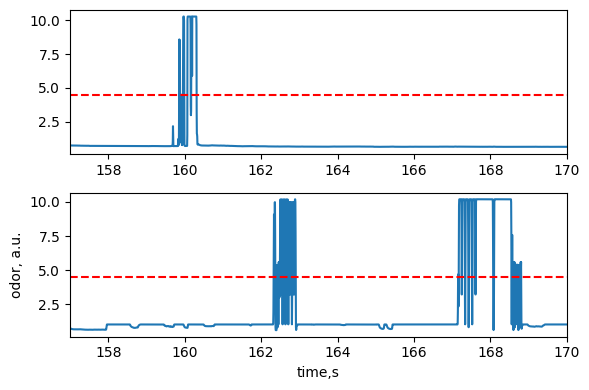

In [1536]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
# ax1.plot(new_test_df1.time, new_test_df1.odor, 'o', label='original',markersize=1)
# ax2.plot(new_test_df2.time, new_test_df2.predicted_odor, 'o' ,label='predicted', markersize=1)
ax1.axhline(4.5, color = 'r', linestyle = '--')
ax2.axhline(4.5, color = 'r', linestyle = '--')

limit=(157,170)
# # limit = (1200,1230)
ax1.set_xlim(limit)
ax2.set_xlim(limit)
# ax1.set_ylim(0,2.5)
# ax2.set_ylim(0,2.5)

ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
# ax1.set_title('Original Odor ')
# ax2.set_title('Predicted Odor')
# ax1.set_title('Original Odor>4.5 ')
# ax2.set_title('Predicted Odor>4.5')
f.tight_layout()

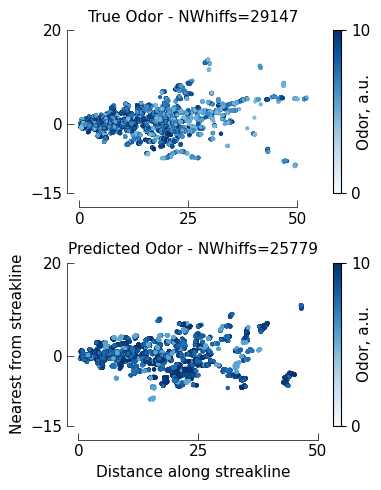

In [1537]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)


# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))

ax[1].set_xlabel('Distance along streakline')
ax[1].set_ylabel('Nearest from streakline')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb3=plt.colorbar(cax3)

cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-10)
# cb3.set_label('P(Whiff Onset)',labelpad=-10)5

cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
# cb3.set_ticks([0, 1])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-15,0,20],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

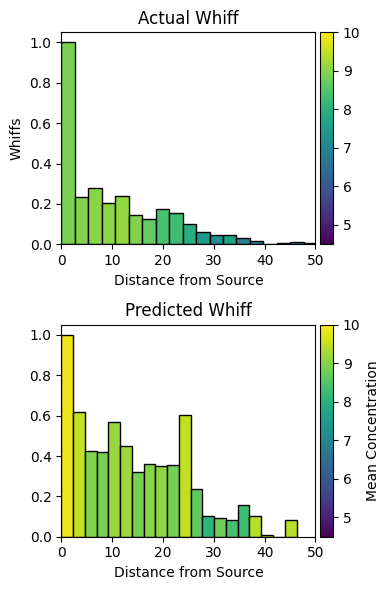

In [1538]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts5
whiff_counts_actual_norm = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_norm = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(4, 6))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4.5, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_norm, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Whiffs')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4.5, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_norm, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
# ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)

f.tight_layout()



In [1539]:
# f,ax=plt.subplots(1,1,figsize=(5,5))
# sns.histplot(new_test_df1.odor, kde=True, ax=ax, label='original odor')5
# sns.histplot(new_test_df2.predicted_odor, kde=True, ax=ax, label='predicted odor')
# ax.set_ylim(0,20000)
# ax.legend()

In [1540]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

In [1541]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

In [1542]:
# fdf1=pd.read_hdf('../data/simulator/plot/odor_stat.h5')
# fdf_predicted=pd.read_hdf('../data/simulator/plot/odor_pr_stat.h5')

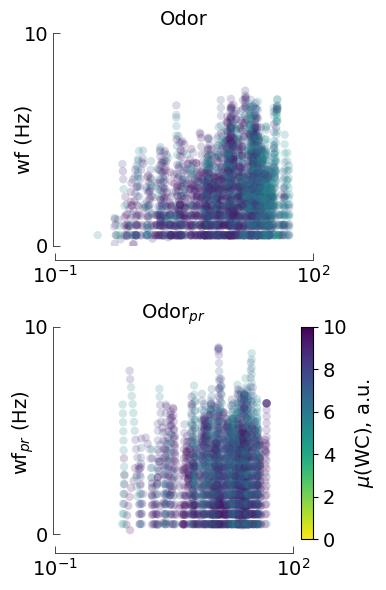

In [1543]:
### WHIFF FREQUENCY5
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

# g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
#                  ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)
ax1.set_ylim(0,)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

# g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
#                  ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('wf (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10],                                    
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10],
                            linewidth=0.5)

ax1.set_ylim(0,)

# Set custom tick labels
# ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])
# ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

In [1494]:
# ### WHIFF Intermittency
# f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# # Plot for actual odor
# var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.odor_intermittency, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
#                   alpha=0.2, vmin=0, vmax=10)
# ax1.set_ylabel('Whiff Frequency (Hz)')

# # g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
# #                  ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
# # g1.set(xlabel=None, ylabel=None)
# ax1.set_ylim(0,)
# ax1.set_title('Odor')

# # Plot for predicted odor
# u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.odor_intermittency, c=fdf_predicted.mean_concentration,
#                 cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

# # g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
# #                  ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
# # g2.set(xlabel=None, ylabel=None)

# # Add color bar only for the predicted odor plot
# divider = make_axes_locatable(ax2)
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
# cbar1.solids.set(alpha=1)
# cbar1.set_label('$\mu$(WC), a.u.')

# # Set the titles and labels
# ax2.set_title('Odor$_{pr}$')
# ax1.yaxis.set_label_coords(-0.08, 0.5)
# ax2.yaxis.set_label_coords(-0.08, 0.5)
# ax1.set_ylabel('Intermittency, s')
# ax2.set_ylabel('Intermittency$_{pr}$ ,s')

# # Adjust spines for both plots
# mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
#                             spine_locations={'left': 1},
#                             smart_bounds=True,
#                             xticks=[-1, 2],
#                             yticks=[0, 70],                                    
#                             linewidth=0.5)
# mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
#                             spine_locations={'left': 1},
#                             smart_bounds=True,
#                             xticks=[-1, 2],
#                             yticks=[0, 70],
#                             linewidth=0.5)

# ax1.set_ylim(0,)

# # Set custom tick labels
# # ax1.set_yticklabels([r'$0$', r'$10$'])
# ax1.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])
# # ax2.set_yticklabels([r'$0$', r'$10$'])
# ax2.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])

# # Set font size and layout
# mpl_functions.set_fontsize(f, 14)
# f.tight_layout()

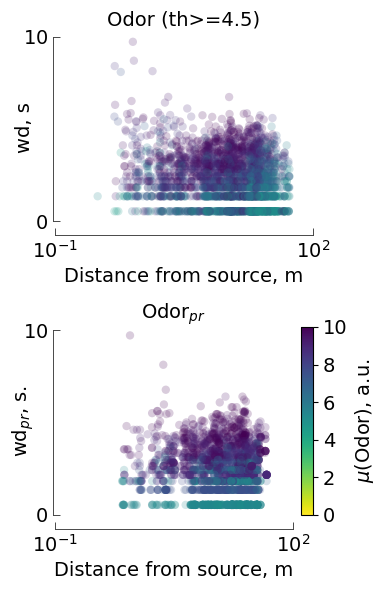

In [1544]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(2,1,figsize=(4,6))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
#             ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('wd, s')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

# g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
#             ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-1,2],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-1,2],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])


mpl_functions.set_fontsize(f, 14)
f.tight_layout()


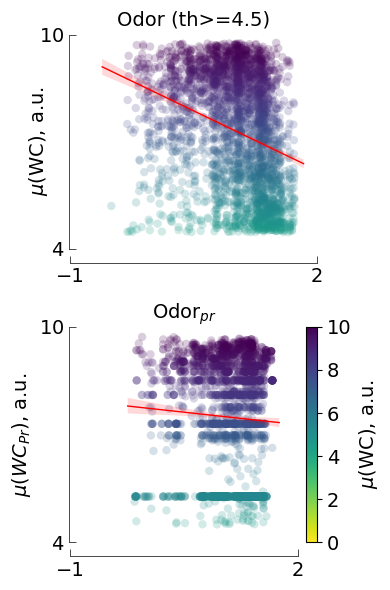

In [1545]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var1 = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[4, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[4, 10.5],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$4$', r'$10$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$4$', r'$10$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


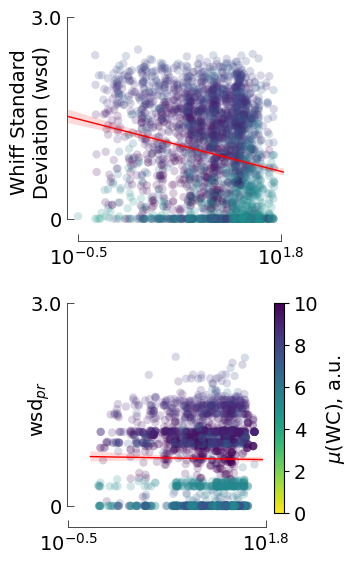

In [1547]:
### WHIFF STANDARD DEVIATION
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.std_whiff, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.std_whiff, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.std_whiff, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('Whiff Standard\nDeviation (wsd)')
ax2.set_ylabel('wsd$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 3.0],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 3.0],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$3.0$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$3.0$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=2)


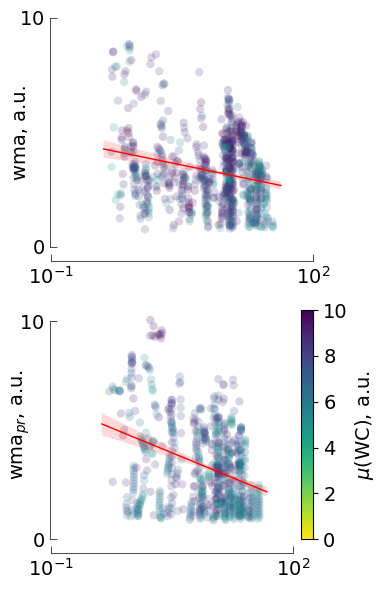

In [1393]:
### WHIFF MOVING AVERAGE
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Moving Average (wma)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.whiff_ma, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.whiff_ma, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('wma, a.u.')
ax2.set_ylabel('wma$_{pr}$, a.u.')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


In [ ]:
# df_test.to_hdf('../data/simulator/plot/hws.h5', key='df_test', mode='w')
# fdf1.to_hdf('../data/simulator/plot/odor_stat.h5', key='df_test', mode='w')
# fdf_predicted.to_hdf('../data/simulator/plot/odor_pr_stat.h5', key='df_test', mode='w')

In [48]:
import statsmodels.formula.api as smf

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf1)
fdf_predicted_new = create_class_column(fdf_predicted)

In [49]:
lookback_time = 10
trainset = fdf_new

D_train = []
mean_time_train = []
Xtrain = []
ytrain = []
Nrows_train = []

# Loop through distance classes, using the modified functions
for distance_class in [0, 1, 2]:
    Xtrain, ytrain, D_train, Nrows_train, mean_time_train = osc.gather_stat_timed(
        trainset, distance_class, lookback_time, Xtrain, ytrain, D_train, Nrows_train, mean_time_train)

# Calculate statistical values
def calc_val(X):
    return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])

# Create a DataFrame to store the results
column_names = ['mc_min', 'mc_max', 'mc_mean', 'mc_std_dev', 'mc_k',
                'wf_min', 'wf_max', 'wf_mean', 'wf_std_dev', 'wf_k',
                'wd_min', 'wd_max', 'wd_mean', 'wd_std_dev', 'wd_k',
                'ma_min', 'ma_max', 'ma_mean', 'ma_std_dev', 'ma_k',
                'st_min', 'st_max', 'st_mean', 'st_std_dev', 'st_k']

traindf = pd.DataFrame(columns=column_names)
c1 = []

# Populate the DataFrame with the smoothed and consistent stats
for i in range(len(Xtrain)):
    if np.size(Xtrain[i]) == 0:
        c1.append(i)
        continue
    else:
        X = []
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i] = np.ravel(X)

# Add additional columns for distance, mean whiff time, and number of whiffs
traindf['distance'] = np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

/tmp/ipykernel_252080/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])
/tmp/ipykernel_252080/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])
/tmp/ipykernel_252080/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])
/tmp/ipykernel_252080/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. T

In [50]:
# traindf.to_hdf('../data/simulator/plot/odor_lt_stat.h5', key='df_test', mode='w')

In [66]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf).fit()
print(distance.summary())

In [51]:
lookback_time = 10

trainset_predicted= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
predictions_filled = []
mean_time_train_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted , mean_time_train_predicted = osc.gather_stat_timed(trainset_predicted, distance_class,
                      lookback_time, Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,
                      mean_time_train_predicted)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain_predicted)):
    if(np.size(Xtrain_predicted[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain_predicted[i])):
            X.append(calc_val(Xtrain_predicted[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)
traindf_predicted['nwhiffs'] = np.delete(Nrows_train_predicted, c1)

/tmp/ipykernel_252080/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_252080/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_252080/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_252080/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs w

In [53]:
# traindf_predicted.to_hdf('../data/simulator/plot/odor_pr_lt_stat.h5', key='df_test', mode='w')

In [68]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf_predicted).fit()
print(distance.summary())

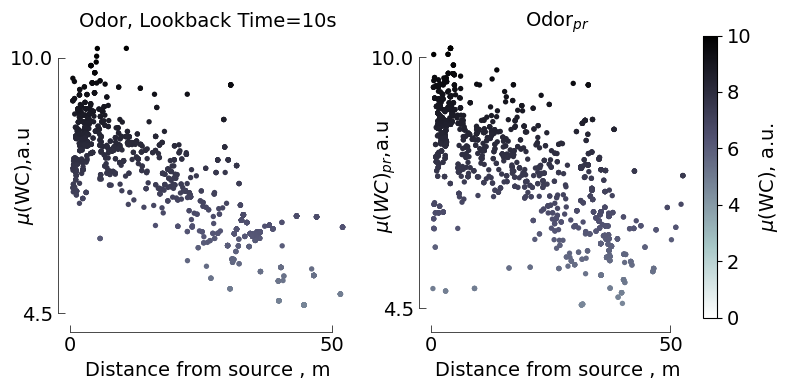

In [54]:
## whiff concentration
f,ax = plt.subplots(1,2,figsize=(8,4))
var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# divider = make_axes_locatable(ax[0])
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
# cbar1.solids.set(alpha=1)
# cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean,c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)

cbar1.set_label('$\mu$(WC), a.u.')
# ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')
ax[0].set_ylabel('$\mu$(WC),a.u')
ax[1].set_ylabel('$\mu(WC)_{pr}$,a.u')
ax[0].set_xlabel('Distance from source , m')
ax[1].set_xlabel('Distance from source , m')

ax[0].set_title('Odor, Lookback Time=10s')
ax[1].set_title('Odor$_{pr}$')

mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5, 10],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5,10],
                            linewidth=0.5)
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


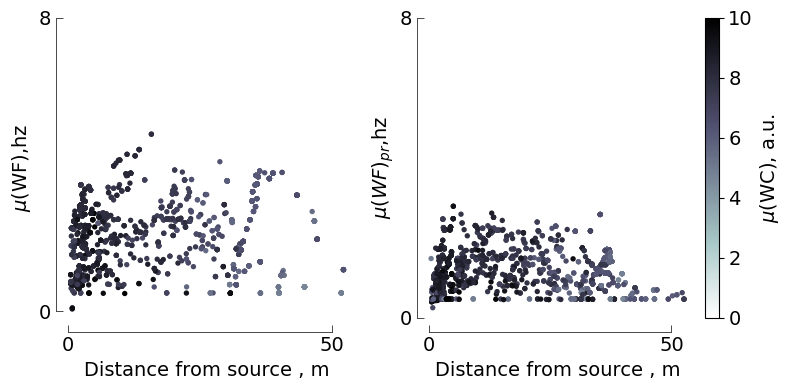

In [55]:
f,ax = plt.subplots(1,2,figsize=(8,4))
var1 =ax[0].scatter(traindf.distance, traindf.wf_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# divider = make_axes_locatable(ax[0])
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
# cbar1.solids.set(alpha=1)
# cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wf_mean,c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)

cbar1.set_label('$\mu$(WC), a.u.')
# ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')
ax[0].set_ylabel('$\mu$(WF),hz')
ax[1].set_ylabel('$\mu(WF)_{pr}$,hz')
ax[0].set_xlabel('Distance from source , m')
ax[1].set_xlabel('Distance from source , m')

# ax[0].set_title('Odor, Lookback Time=10s')
# ax[1].set_title('Odor$_{pr}$')

mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[0,8],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[0,8],
                            linewidth=0.5)
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

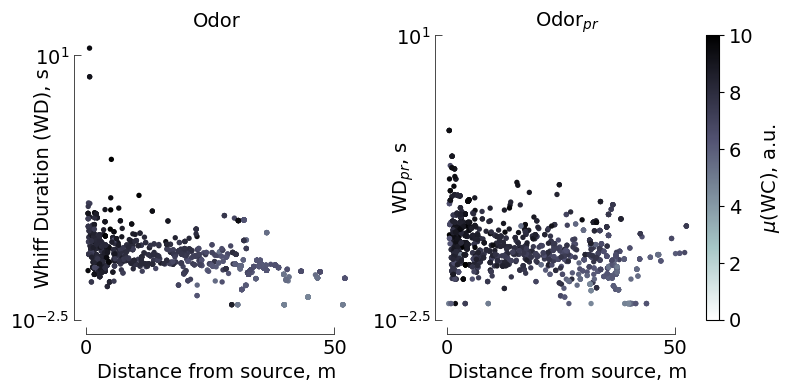

In [56]:
## WHIFF DURATION
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual whiff duration
var1 = ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Plot for predicted whiff duration
var2 = ax[1].scatter(traindf_predicted.distance, traindf_predicted.wd_mean, c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Add color bar for the predicted plot only
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set labels and titles
ax[0].set_ylabel('Whiff Duration (WD), s')
ax[1].set_ylabel('WD$_{pr}$, s')
ax[0].set_xlabel('Distance from source, m')
ax[1].set_xlabel('Distance from source, m')
ax[0].set_title('Odor')
ax[1].set_title('Odor$_{pr}$')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[-2.5, 1.0],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[-2.5, 1.0],
                            linewidth=0.5)

# Adjust label positions
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)

ax[0].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax[1].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=1)


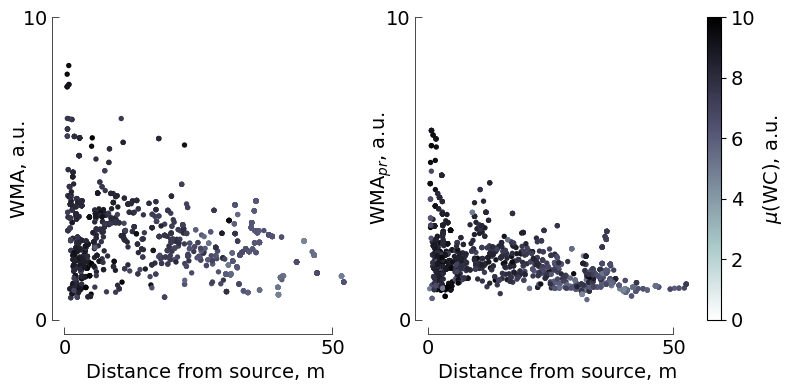

In [57]:
## WHIFF MOVING AVERAGE (WMA)
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual WMA
var1 = ax[0].scatter(traindf.distance, traindf.ma_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Plot for predicted WMA
var2 = ax[1].scatter(traindf_predicted.distance, traindf_predicted.ma_mean, c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Add color bar for the predicted plot only
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set labels and titles
ax[0].set_ylabel('WMA, a.u.')
ax[1].set_ylabel('WMA$_{pr}$, a.u.')
ax[0].set_xlabel('Distance from source, m')
ax[1].set_xlabel('Distance from source, m')
# ax[0].set_title('Odor')
# ax[1].set_title('Odor$_{pr}$')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,11],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,10],
                            linewidth=0.5)

# Adjust label positions
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
ax[0].set_yticklabels([r'$0$', r'$10$'])
# ax[0].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax[1].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=1)
plt.show()


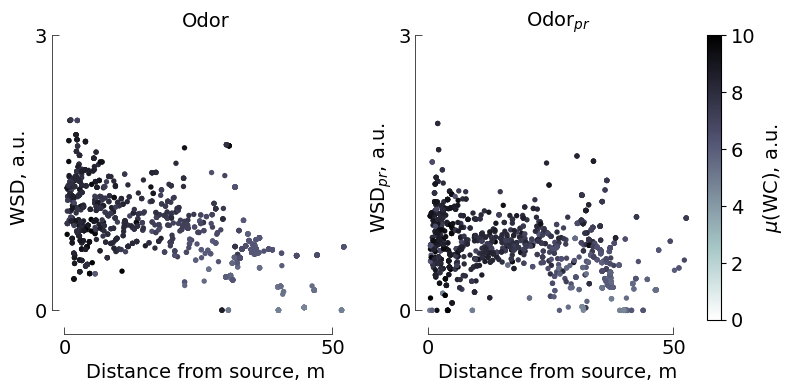

In [58]:
## WHIFF STANDARD DEVIATION (WSD)
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual WSD
var1 = ax[0].scatter(traindf.distance, traindf.st_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Plot for predicted WSD
var2 = ax[1].scatter(traindf_predicted.distance, traindf_predicted.st_mean, c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Add color bar for the predicted plot only
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set labels and titles
ax[0].set_ylabel('WSD, a.u.')
ax[1].set_ylabel('WSD$_{pr}$, a.u.')
ax[0].set_xlabel('Distance from source, m')
ax[1].set_xlabel('Distance from source, m')
ax[0].set_title('Odor')
ax[1].set_title('Odor$_{pr}$')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,3],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,3],
                            linewidth=0.5)

# Adjust label positions
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)

# ax[0].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax[1].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=1)
plt.show()
